In [1]:
import jax
import jax.numpy as np
import jax.random as jnp_random
import numpy as onp
from functools import partial
from jax import grad, jacrev, jacfwd, jit, vmap
from jax.scipy.special import logsumexp
from jax.lax import scan
from jax.example_libraries import optimizers
from jax.numpy import concatenate as cat
import timeit

import random
import pickle as pkl
import scipy

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [2]:
@jit
def p(x): # uniform distribution
    return np.exp(-50.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.75)**2)) \
                + 0.*np.exp(-50.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2))

@jit
def f(x, u, dt): # dynamics
    xnew = x + dt*u#np.tanh(u)
    return xnew, x

def get_hk(k): # normalizing factor for basis function
    _hk = (2. * k + onp.sin(2 * k))/(4. * k)
    _hk = _hk.at[onp.isnan(_hk)].set(1.)
    return onp.sqrt(onp.prod(_hk))

def fk(x, k): # basis function
    return np.prod(np.cos(x*k))


k1, k2 = np.meshgrid(*[np.arange(0, 16, step=1)]*2)
k = np.stack([k1.ravel(), k2.ravel()]).T
k = np.pi*k

lamk = (1.+np.linalg.norm(k/np.pi,axis=1)**2)**(-4./2.)
# lamk = np.exp(-0.8 * np.linalg.norm(k, axis=1))
# lamk = np.ones((len(k), 1))
hk = []
for ki in k:
    hk.append(get_hk(ki))
hk = np.array(hk)

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)
def get_ck(tr, k, dt, tf):
    ck = np.sum(vmap(partial(fk_vmap, tr))(k), axis=1)
    ck = ck / hk
    ck = ck * dt / tf
    return ck

N = 100

# @jit
def fourier_ergodic_loss(u, x0, phik, k, tf):
    dt = tf/N
    xf, tr = scan(partial(f, dt=dt), x0, u)
    ck = get_ck(tr, k, dt, tf)
    barr_cost = 100.*np.sum(np.maximum(0, tr-1)**2 + np.maximum(0, -tr)**2)
    return np.sum(lamk*np.square(phik - ck)) \
            + 1e-5 * np.mean(u**2) + barr_cost + tf#np.mean((tr - np.array([0.5,0.5]))**8)

dl = jit(grad(fourier_ergodic_loss))

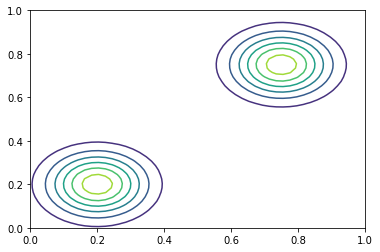

In [3]:
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))

In [4]:
phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(_s, k), vmap(p)(_s))
phik = phik/phik[0]
phik = phik/hk

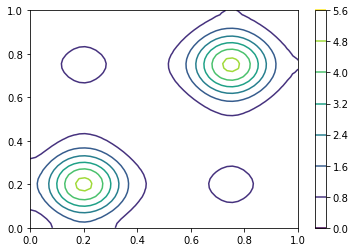

In [5]:
phik_recon = np.dot(phik, vmap(fk_vmap, in_axes=(None, 0))(_s, k)).reshape(X.shape)
plt.contour(X, Y, phik_recon)
plt.colorbar()

In [6]:
# initial conditions
x0 = np.array([0.54,0.3])
u  = np.zeros((100,2))
tf = np.array(2.0)

In [7]:
fourier_ergodic_loss(u, x0, phik, k, tf)

DeviceArray(2.5900526, dtype=float32)

In [8]:
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(u)

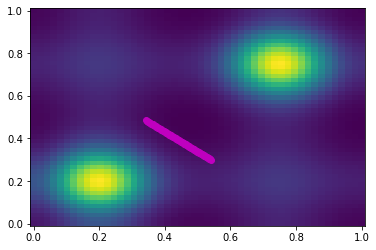

In [9]:
log = []
for i in range(1500):
    g = dl(get_params(opt_state), x0, phik, k, tf)
    tf = np.maximum(0.2, tf - 0.1*grad(fourier_ergodic_loss, argnums=4)(u, x0, phik, k, tf))
    opt_state = opt_update(i, g, opt_state)
    
    if (i+1) % 100 == 0:
        u = get_params(opt_state)
        log.append(fourier_ergodic_loss(u, x0, phik, k, tf).copy())
        clear_output(wait=True)
        dt = tf/N
        xf, tr = scan(partial(f,dt=dt), x0, u)
        
        clear_output(wait=True)
        plt.pcolormesh(X, Y, phik_recon)
        plt.scatter(tr[:,0],tr[:,1], c='m')
#         plt.ylim(0,1)
#         plt.xlim(0,1)
        plt.pause(0.0001)
        i+=1
        plt.show()


In [10]:
tf

DeviceArray(-86.589424, dtype=float32, weak_type=True)